In [1]:
!pip install transformers

In [6]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text

In [7]:
!pip install tf-models-official

In [4]:
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import *

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

import re

import seaborn as sns
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud

nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


เนื่องจากข้อมูล labeled.csv นั้นมีความ imbalance class อย่างมากจึงหา external data เพิ่มเติมเพื่อทำให้ข้อมูลมีความ balance calss มากขึ้นโดยใช้ข้อมูลจาก Twitter

In [6]:
df_twitter = (pd.read_csv("/content/drive/MyDrive/HateSpeechDetection/data/test.csv")
              .rename(columns={"tweet": "text"}))
df_twitter.drop('id',axis=1,inplace=True)
df_twitter.head()

,text
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [7]:
df_offensive = (pd.read_csv("/content/drive/MyDrive/HateSpeechDetection/data/labeled_data.csv", index_col=0)
      .rename(columns={"class": "label", "tweet": "text"}))

# df_offensive["category"] = df_offensive["label"].map({0: "Hate Speech",
#                                     1: "Offensive Language",
#                                     2: "No Hate and Offensive"})

df_offensive = df_offensive[['text', 'label']]
df_offensive.loc[df_offensive['label']==0, 'label'] = 1
df_offensive.loc[df_offensive['label']==2, 'label'] = 0
df_offensive.head()

,text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [8]:
frame=[df_twitter,df_offensive]
df = pd.concat(frame)
df.head()

,text,label
0,#studiolife #aislife #requires #passion #dedic...,NaN
1,@user #white #supremacists want everyone to s...,NaN
2,safe ways to heal your #acne!! #altwaystohe...,NaN
3,is the hp and the cursed child book up for res...,NaN
4,"3rd #bihday to my amazing, hilarious #nephew...",NaN


In [ ]:
# # Downsampling
# min_samples = df['label'].value_counts().min()

# df = pd.concat([
#     df[df['label'] == i].sample(min_samples, random_state=42)
#     for i in range(2)  # Assuming labels are 0, 1, and 2
# ]).reset_index(drop=True)

# df

###### Statistic Descriptive

Text(0.5, 1.0, 'Distribution of sentiments')

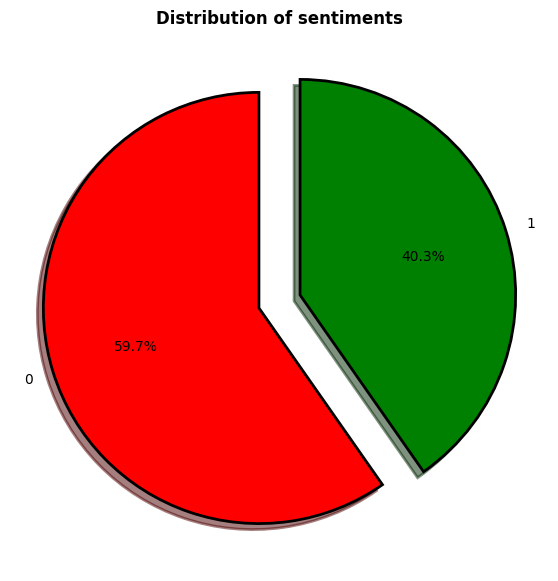

In [ ]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = df['label'].value_counts()
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments", fontweight='bold')

In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,
)
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,
)
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['label', 'data_type']).count()

text
label data_type       
0     test        5856
      train      19917
      val         8110
1     test        4225
      train      12376
      val         6261

###### Preprocessing text

In [ ]:
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def clean_text(text):
    text = str(text).lower()
    patterns = [
        ('\[.*?\]', ''),
        ('https?://\S+|www\.\S+', ''),
        ('<.*?>+', ''),
        (r"\@w+|\#", ''),
        (r"[^\w\s]", ''),
        (f'[{re.escape(string.punctuation)}]', ''),
        ('\n', ''),
        ('\w*\d\w*', ''),
    ]
    for pattern, repl in patterns:
        text = re.sub(pattern, repl, text)
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word, wordnet.VERB) for word in tokens if word not in stopword]
    return " ".join(lemmatized_tokens)

df['text'] = df['text'].apply(clean_text)

###### visualization

In [ ]:
def plot_wordcolund(df):
    words = " ".join(df['text'])
    stopword = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopword, background_color='white', max_words=2000, height = 2000, width=4000).generate(words)
    plt.figure(figsize = (16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

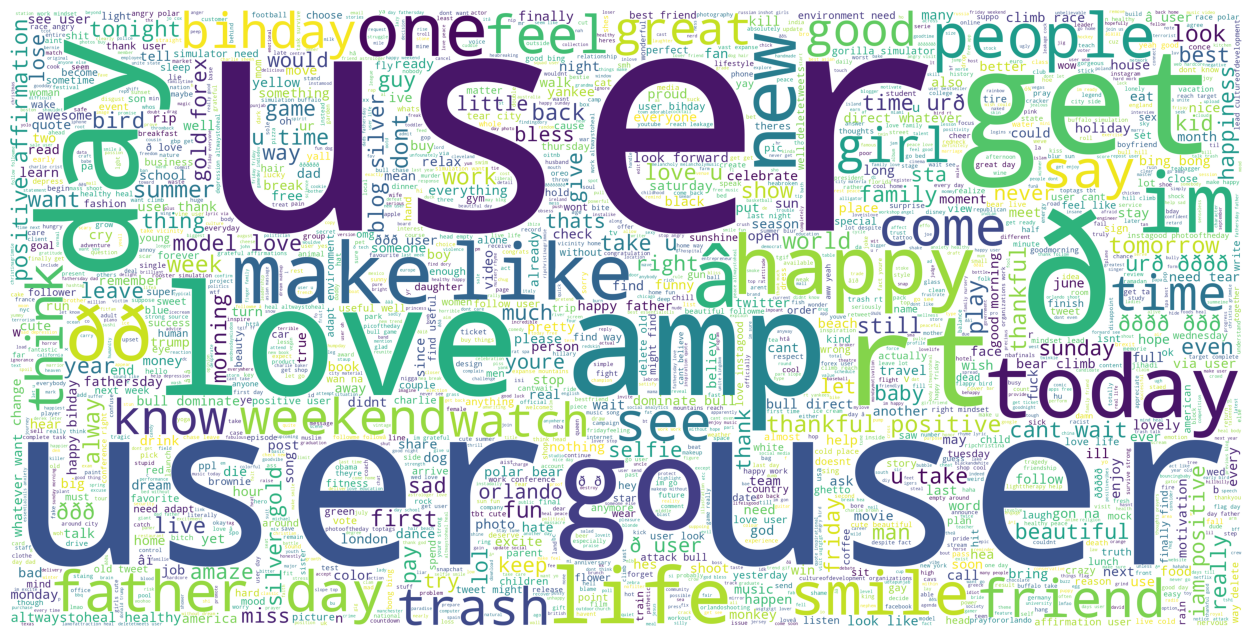

In [ ]:
plot_wordcolund(df[df['label']==0])

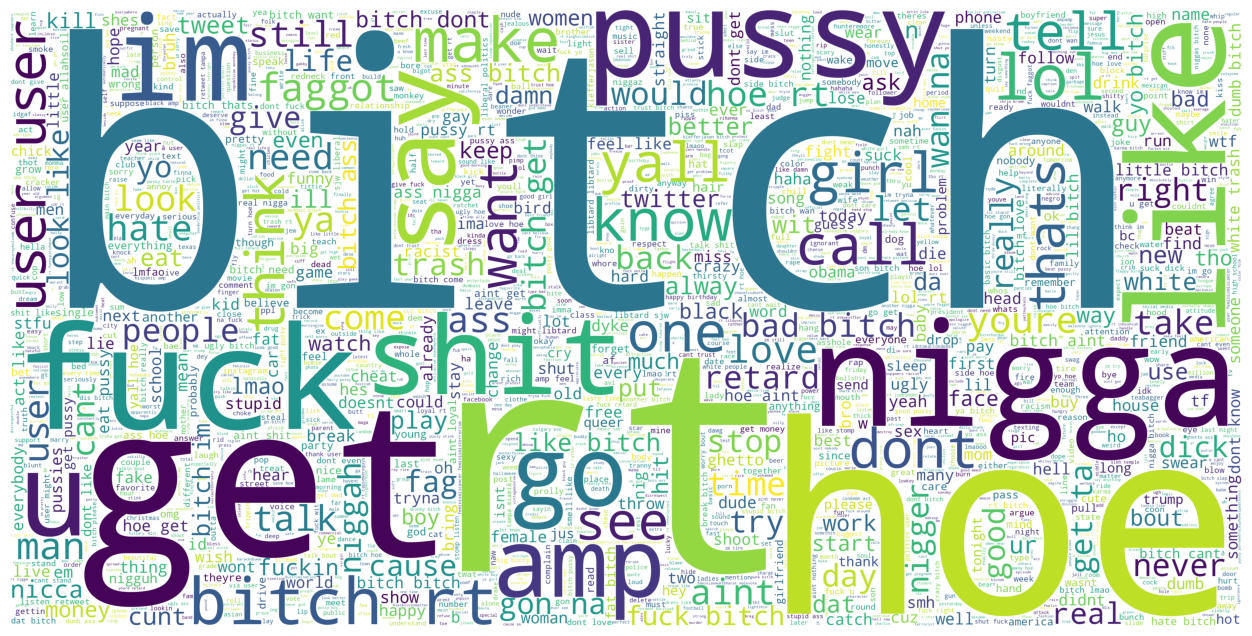

In [ ]:
plot_wordcolund(df[df['label']==1])

In [ ]:
from collections import Counter
from nltk.util import ngrams

def get_top_n_gram(df, ngram_range, n=10):
    # Tokenization using pythainlp
    words = " ".join(text for text in df['text'] if isinstance(text, str))
    tokens = words.split(" ")

    # Extract bigrams (2-grams)
    bigrams = list(ngrams(tokens, ngram_range))

    # Count the bigrams
    bigram_counts = Counter(bigrams)
    # Convert to DataFrame
    df = pd.DataFrame([( ' '.join(k), v) for k, v in bigram_counts.items()], columns=['words', 'counts'])
    df = df.sort_values('counts', ascending=False).reset_index(drop=True).head(n)
    return df

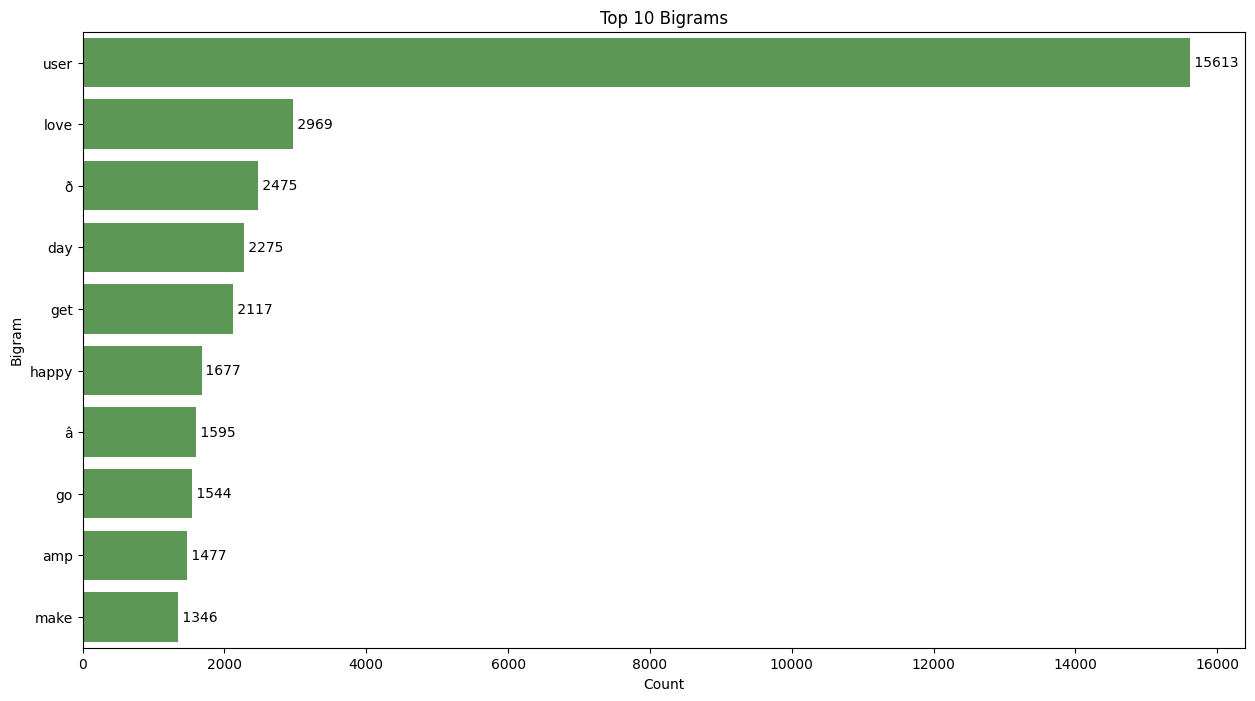

In [ ]:
top_10 = get_top_n_gram(df[df['label']==0], 1, 10)

# Plotting
plt.figure(figsize=(15,8))
sns.barplot(data=top_10, x='counts', y='words', orient='h', color='#54A24B')

# Adding text to the graph for each bar
for index, value in enumerate(top_10['counts']):
    plt.text(value-3, index, f' {value}', color='black', va="center")

plt.title('Top 10 Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Count')
plt.show()

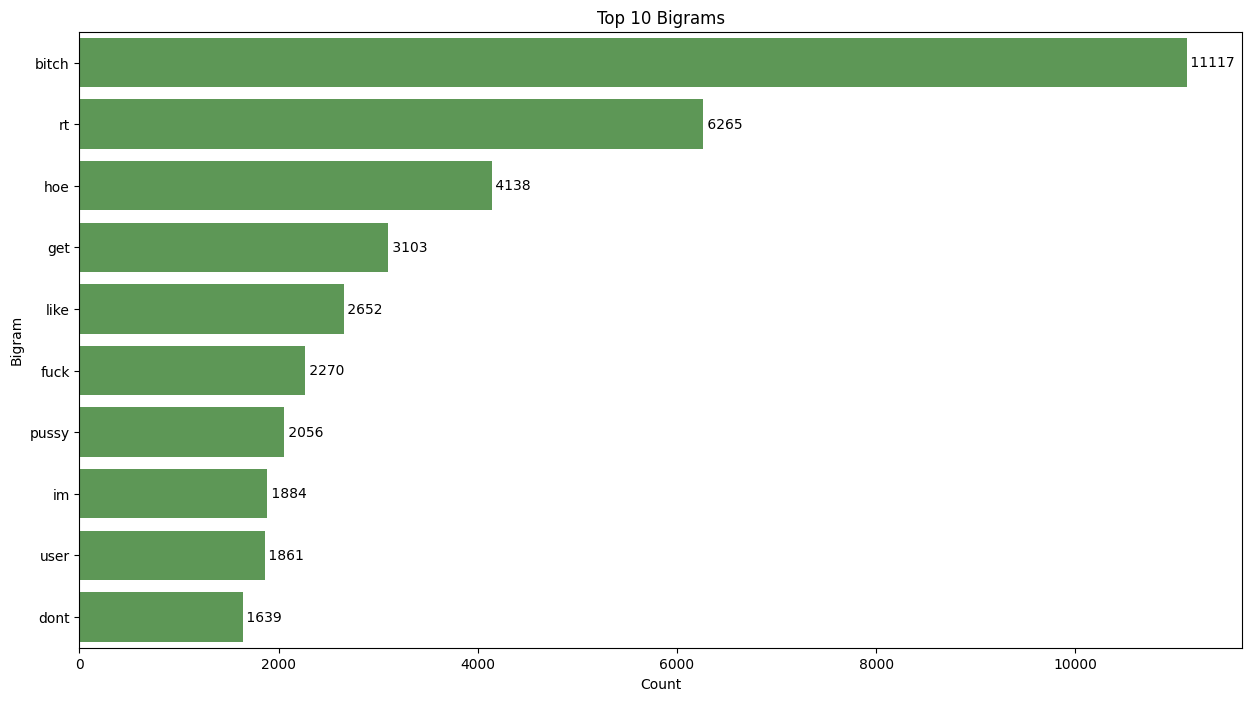

In [ ]:
top_10 = get_top_n_gram(df[df['label']==1], 1, 10)

# Plotting
plt.figure(figsize=(15,8))
sns.barplot(data=top_10, x='counts', y='words', orient='h', color='#54A24B')

# Adding text to the graph for each bar
for index, value in enumerate(top_10['counts']):
    plt.text(value-3, index, f' {value}', color='black', va="center")

plt.title('Top 10 Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Count')
plt.show()

###### Train-Test Bert Model

In [ ]:
df_train = df.loc[df["data_type"]=="train"].sample(frac=1)
df_val = df.loc[df["data_type"]=="val"].sample(frac=1)
df_test = df.loc[df["data_type"]=="test"].sample(frac=1)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values)).batch(32, drop_remainder=False)
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values)).batch(32, drop_remainder=False)
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values)).batch(32, drop_remainder=False)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
# bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [ ]:
hate, nonhate = np.bincount(df['label'])
total = hate + hate

weight_for_0 = (1 / hate)*(total)/2.0
weight_for_1 = (1 / nonhate)*(total)/2.0


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.48


In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

classifier_model.get_weights()[-1]
classifier_model.summary()
tf.keras.utils.plot_model(classifier_model)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#metrics = tf.metrics.Accuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

c:\Users\User\miniconda3\envs\tf-text\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1010/1010 [==============================] - 217s 211ms/step - loss: 0.3292 - accuracy: 0.8842 - val_loss: 0.1585 - val_accuracy: 0.9400
Epoch 2/5
1010/1010 [==============================] - 213s 211ms/step - loss: 0.1843 - accuracy: 0.9466 - val_loss: 0.1595 - val_accuracy: 0.9404
Epoch 3/5
1010/1010 [==============================] - 213s 211ms/step - loss: 0.1404 - accuracy: 0.9626 - val_loss: 0.1779 - val_accuracy: 0.9429
Epoch 4/5
1010/1010 [==============================] - 213s 211ms/step - loss: 0.1133 - accuracy: 0.9713 - val_loss: 0.2000 - val_accuracy: 0.9435
Epoch 5/5
316/316 [==============================] - 26s 83ms/step - loss: 0.2422 - accuracy: 0.9418
Loss: 0.24223005771636963
Accuracy: 0.9417716264724731


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


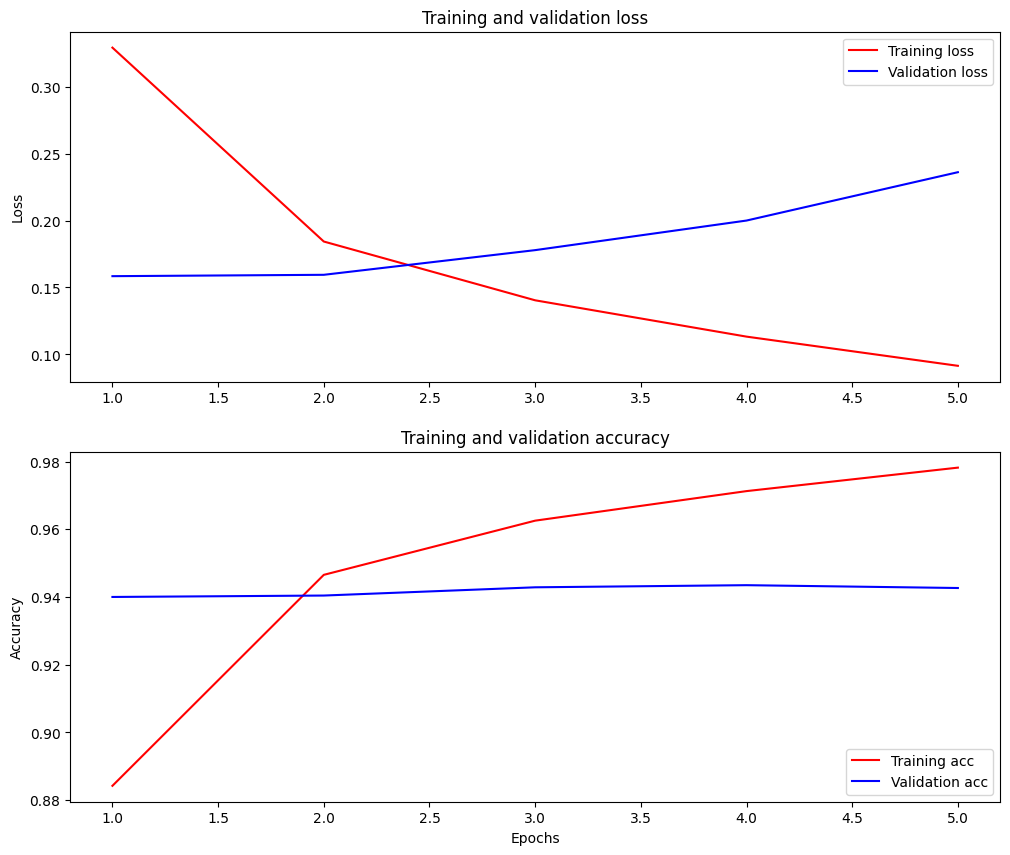

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
y_pred =  classifier_model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=-1)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(df_val.label, y_pred))
print(classification_report(df_val.label, y_pred))

450/450 [==============================] - 37s 82ms/step
[[7648  462]
 [ 362 5899]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8110
           1       0.93      0.94      0.93      6261

    accuracy                           0.94     14371
   macro avg       0.94      0.94      0.94     14371
weighted avg       0.94      0.94      0.94     14371



In [ ]:
df.label = df.label.map({1: 'Hate Speech', 0: 'No Hate Speech'})
df.to_csv('tweet.csv', encoding='utf-8')

In [ ]:
del df['data_type']

In [ ]:
y_pred =  classifier_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=-1)

from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(df_test.label, y_pred)
print(classification_report(df_test.label, y_pred))

316/316 [==============================] - 26s 81ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5856
           1       0.92      0.94      0.93      4225

    accuracy                           0.94     10081
   macro avg       0.94      0.94      0.94     10081
weighted avg       0.94      0.94      0.94     10081



In [ ]:
# classifier_model.save('BERT_HateSpeechDetection.h5')
# classifier_model.save_weights('BERT_HateSpeechDetection.h5')